# Train model to recognise voice of people 

In [1]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
clean_data = validate[validate['client_id'].isin(valid_client_ids)][['client_id', 'path']]

In [11]:
def filter_sample_by_clients_ids(data: pd.DataFrame, max_count: int = 500, min_count: int = 4):
	sample_count = data['client_id'].value_counts()
	clients_ids = [e for e in sample_count[sample_count < max_count][sample_count > min_count].index]
	return data[data['client_id'].isin(clients_ids)][['client_id', 'path']]

def concatenation(train_data: pd.DataFrame, anchor: pd.DataFrame, posneg: pd.DataFrame) -> pd.DataFrame:
		data_particle_case = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
		data_particle_case[['anchor_client_id', 'anchor_path', 'anchor_source']] = anchor
		data_particle_case[['posneg_client_id', 'posneg_path', 'posneg_source']] = posneg
		return pd.concat([train_data, data_particle_case], ignore_index=True)

def data_generation_base(data: pd.DataFrame, data_frac: int = 1):
	client_ids = data['client_id'].unique()
	data['source'] = 'original'
	
	res_data = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
	for id in client_ids:
		client_id_sample = data[data['client_id'] == id] 
		no_client_id_sample = data[data['client_id'] != id]

		anchor_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_original, positive_original)

		anchor_neg_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_generated = no_client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_neg_original, negative_generated)
	return res_data


In [17]:
import librosa

from src.columns.base_dataset_column import DatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation

class UniversalDS(Dataset):
	def __init__(
		self,
		voice_dataset,
		voice_data_path,
		generated_voice_dataset = None,
		generated_voice_data_path = None,
		sample_rate=16000,
		duration=3,
		transform=None
	):
		self.voice_dataset = voice_dataset
		self.generated_voice_dataset = generated_voice_dataset
		self.voice_data_path = str(voice_data_path)
		self.generated_voice_data_path = str(generated_voice_data_path)
		self.duration = duration
		self.sample_rate = sample_rate
		if transform is not None:
			self.transform = transform
		else:
			self.transform = CompositeTransformation(
				[
					ResampleTransform(target_sample_rate=sample_rate),
					CustomAdjustDurationTransform(duration_seconds=duration),
					ToMelSpectrogramTransform(
						sample_rate=sample_rate, n_mels=64, n_fft=512)
				]
			)
		self.mix_dataset()

	def __len__(self):
		return len(self.temp_dataset)

	def _get_sample(self, audio_file):
		audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
		sample = self.transform.transform((audio, sample_rate))
		return sample

	def _get_sample_path(self, path):
		return self.voice_data_path + path

	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label =  anchor_client_id == posneg_client_id
		return torch.tensor(1 if label else 0, dtype=torch.int64)
	
	def mix_dataset(self):
		self.temp_dataset = data_generation_base(self.voice_dataset)
		self.reset_iteration()

	def reset_iteration(self):
		self.iteration_to_mix = len(self.temp_dataset)

	def __getitem__(self, idx):

		anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.temp_dataset.iloc[idx][
			[
				DatasetColumn.ANCHOR_PATH,
				DatasetColumn.POSNEG_PATH,
				DatasetColumn.ANCHOR_ID,
				DatasetColumn.POSNEG_ID,
				DatasetColumn.SOURCE_ANCHOR,
				DatasetColumn.SOURCE_POSNEG,
			]
		].values.tolist()

		anchor_file = self._get_sample_path(anchor_path)
		posneg_file = self._get_sample_path(posneg_path)
		label = self._get_label(anchor_client_id, posneg_client_id, anchor_source, posneg_source)
		anchor_sample = self._get_sample(anchor_file)
		posneg_sample = self._get_sample(posneg_file)
		self.iteration_to_mix -= 1
		if self.iteration_to_mix == 0:
			self.mix_dataset()
		return anchor_sample, posneg_sample, label

In [18]:
DATASET_PATH = './data/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'

In [19]:
train_ds = pd.read_csv(DATASET_PATH + "validated.tsv",  sep='\t')
train_df = BaseSoundDS(train_ds, DATA_PATH + "validated_16000/")

mix


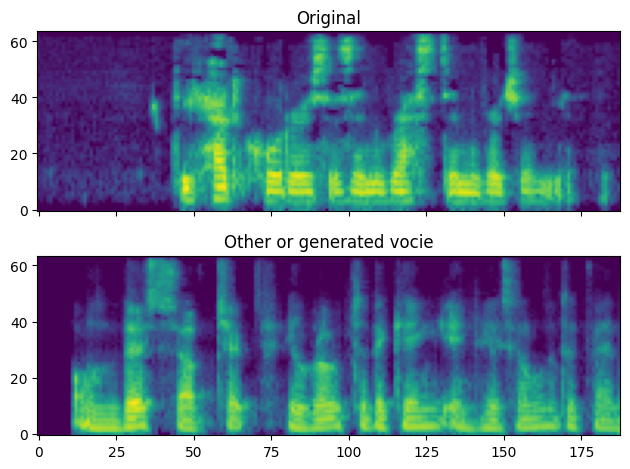

In [20]:
from src.utils.plot import plot

plot(train_df[8])

In [24]:
for i in range(len(train_df)*3):
	train_df[i//len(train_df)]

mix
mix
mix


In [26]:
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				self.conv_layers = nn.Sequential(
						nn.ReflectionPad2d(1),
						nn.Conv2d(1, 32, kernel_size=4),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(32, 64, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(64, 128, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(128, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(256, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=5, stride=2),
				)
				self.fc_layers = nn.Sequential(
						nn.Linear(4608, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [27]:
num_items = len(train_df)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(train_df, [num_train, num_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [28]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred) for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)

	return avg_loss, accuracy, precision, recall, f1

In [29]:
def train_siamese_model(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	predictions = []
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		
		optimizer.zero_grad()
		output = model(anchor_sgram, posneg_sgram)
		loss = criterion(output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		predictions += [torch.argmax(pred) for pred in output.cpu()]
		true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss, accuracy, precision, recall, f1

In [30]:
class CrossEntropyLoss(torch.nn.Module):
	def __init__(self):
		super(CrossEntropyLoss, self).__init__()

	def forward(self, output, label):
		label = label.long()
		loss = F.cross_entropy(output, label)
		return loss

In [31]:
num_epochs = 15
siamese_model = SiameseNetwork().to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate(siamese_model, val_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])


Epoch 1/15, Loss: 0.5971, Accuracy: 0.6603, Precision: 0.7081, Recall: 0.5486, F1: 0.6182


Epoch 1/15, Loss: 0.6052, Accuracy: 0.6698, Precision: 0.6975, Recall: 0.5875, F1: 0.6378


Epoch 2/15, Loss: 0.5120, Accuracy: 0.7495, Precision: 0.7452, Recall: 0.7602, F1: 0.7526


Epoch 2/15, Loss: 0.4802, Accuracy: 0.7695, Precision: 0.7838, Recall: 0.7376, F1: 0.7600


Epoch 3/15, Loss: 0.4251, Accuracy: 0.8130, Precision: 0.7958, Recall: 0.8433, F1: 0.8189


Epoch 3/15, Loss: 0.4759, Accuracy: 0.7808, Precision: 0.7237, Recall: 0.9011, F1: 0.8027


Epoch 4/15, Loss: 0.3845, Accuracy: 0.8323, Precision: 0.8194, Recall: 0.8536, F1: 0.8361


Epoch 4/15, Loss: 0.3753, Accuracy: 0.8373, Precision: 0.8017, Recall: 0.8916, F1: 0.8443


Epoch 5/15, Loss: 0.3274, Accuracy: 0.8626, Precision: 0.8464, Recall: 0.8869, F1: 0.8662


Epoch 5/15, Loss: 0.3929, Accuracy: 0.8420, Precision: 0.8129, Recall: 0.8840, F1: 0.8470


Epoch 6/15, Loss: 0.2962, Accuracy: 0.8772, Precision: 0.8685, Recall: 0.8897, F1: 0.8790


Epoch 6/15, Loss: 0.3521, Accuracy: 0.8504, Precision: 0.8169, Recall: 0.8992, F1: 0.8561


Epoch 7/15, Loss: 0.2372, Accuracy: 0.9036, Precision: 0.8949, Recall: 0.9151, F1: 0.9049


Epoch 7/15, Loss: 0.4015, Accuracy: 0.8382, Precision: 0.8512, Recall: 0.8156, F1: 0.8330


Epoch 8/15, Loss: 0.2032, Accuracy: 0.9193, Precision: 0.9147, Recall: 0.9254, F1: 0.9200


Epoch 8/15, Loss: 0.3984, Accuracy: 0.8674, Precision: 0.8456, Recall: 0.8954, F1: 0.8698


Epoch 9/15, Loss: 0.1805, Accuracy: 0.9301, Precision: 0.9257, Recall: 0.9357, F1: 0.9307


Epoch 9/15, Loss: 0.3915, Accuracy: 0.8579, Precision: 0.8238, Recall: 0.9068, F1: 0.8633


Epoch 10/15, Loss: 0.1380, Accuracy: 0.9442, Precision: 0.9401, Recall: 0.9493, F1: 0.9447


Epoch 10/15, Loss: 0.4443, Accuracy: 0.8598, Precision: 0.8446, Recall: 0.8783, F1: 0.8611


Epoch 11/15, Loss: 0.1170, Accuracy: 0.9567, Precision: 0.9551, Recall: 0.9587, F1: 0.9569


Epoch 11/15, Loss: 0.4802, Accuracy: 0.8523, Precision: 0.8324, Recall: 0.8783, F1: 0.8548


Epoch 12/15, Loss: 0.1032, Accuracy: 0.9624, Precision: 0.9616, Recall: 0.9634, F1: 0.9625


Epoch 12/15, Loss: 0.5389, Accuracy: 0.8551, Precision: 0.8957, Recall: 0.8004, F1: 0.8454


Epoch 13/15, Loss: 0.1332, Accuracy: 0.9537, Precision: 0.9510, Recall: 0.9568, F1: 0.9539


Epoch 13/15, Loss: 0.5028, Accuracy: 0.8354, Precision: 0.8589, Recall: 0.7985, F1: 0.8276


Epoch 14/15, Loss: 0.0738, Accuracy: 0.9715, Precision: 0.9683, Recall: 0.9751, F1: 0.9717


Epoch 14/15, Loss: 0.5985, Accuracy: 0.8504, Precision: 0.8318, Recall: 0.8745, F1: 0.8526


Epoch 15/15, Loss: 0.0765, Accuracy: 0.9751, Precision: 0.9760, Recall: 0.9742, F1: 0.9751


Epoch 15/15, Loss: 0.6715, Accuracy: 0.8325, Precision: 0.8734, Recall: 0.7738, F1: 0.8206


In [41]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")
	plt.tight_layout()
	plt.show()

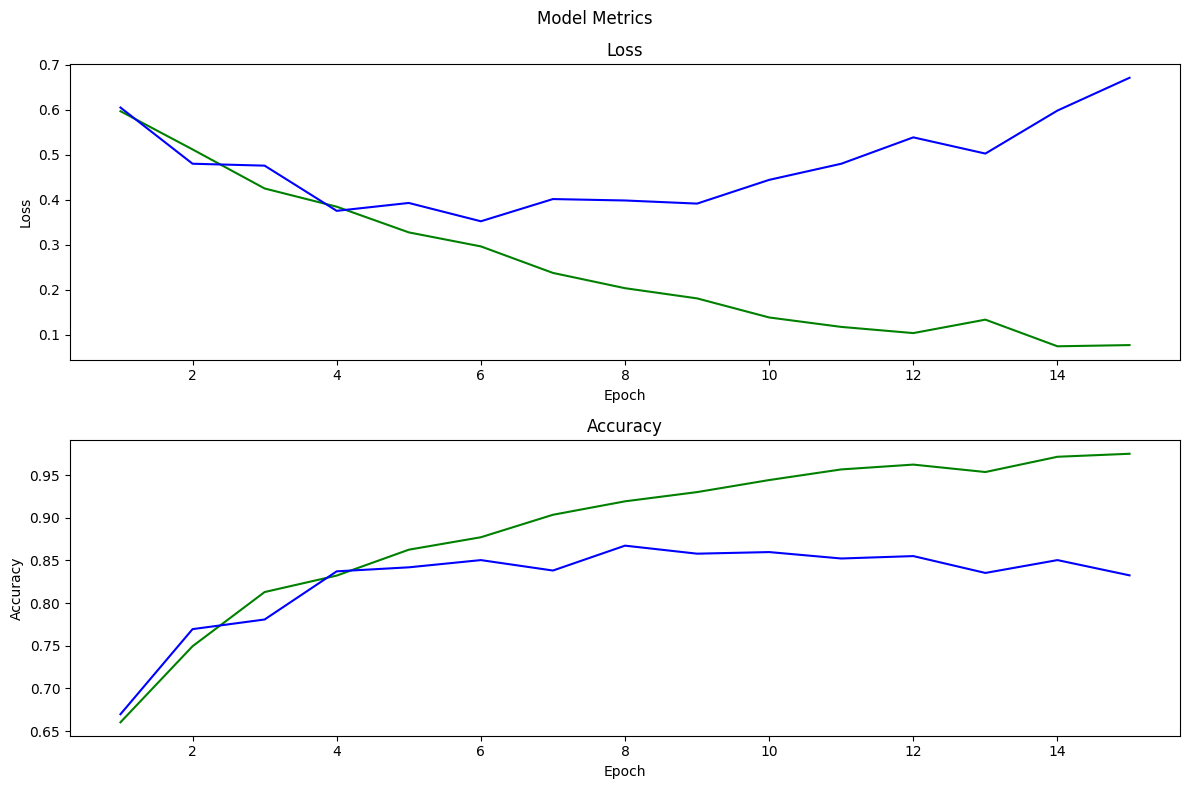

In [39]:
plot_metrix(loss, accuracy)

In [51]:
def save_model(model, model_name, base_path = './model_save/'):
	model.cpu()
	model.eval()
	torch.save(model, base_path + model_name)

In [57]:
save_model(siamese_model, "base_cnn.pt")

In [59]:
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv").dropna()
test_ds = BaseSoundDS(test_df,  DATA_PATH + './validated_16000/')

test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


In [61]:
siamese_model.to(device)
_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate(siamese_model, test_dl, criterion, device)
print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 15/15, Loss: 0.9084, Accuracy: 0.8188, Precision: 0.8161, Recall: 0.8232, F1: 0.8196


In [62]:
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad[0]), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad[0]), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad

In [63]:

def plot_explain_siamese_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad):
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title("Anchor Sgram Grad")
	plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	plt.title("PosNeg Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title("PosNeg Sgram Grad")
	plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.show()

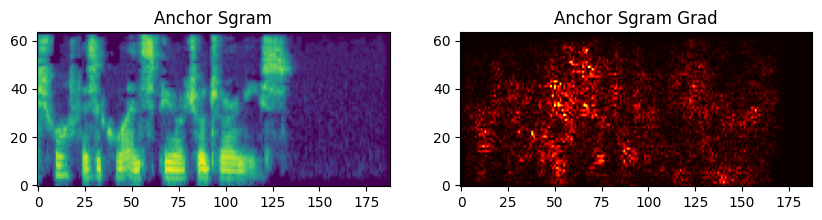

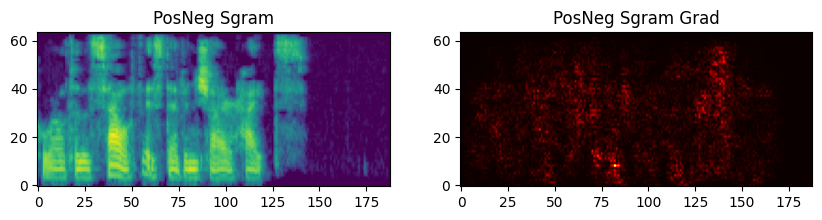

In [65]:
from src.utils.plot import plot_explain_siamese_model_all

anchor_sgram, posneg_sgram, _ = test_ds[4]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad)

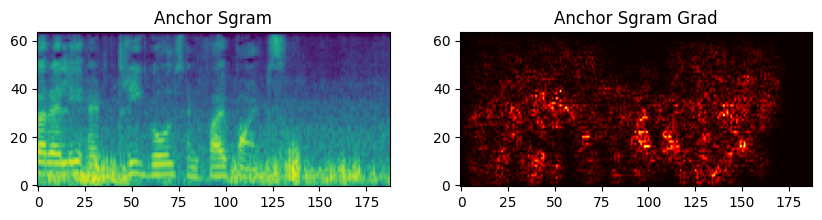

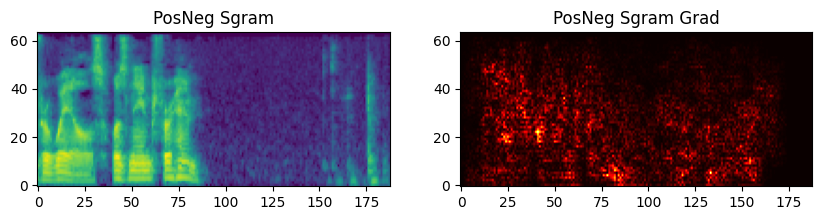

In [67]:
from src.utils.plot import plot_explain_siamese_model_all

anchor_sgram, posneg_sgram, _ = train_ds[0]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad)

In [68]:
def integrated_gradients(model,anchor_sgram, posneg_sgram, baseline=None, num_steps=5):

	if baseline is None:
		anchor_baseline = torch.zeros_like(anchor_sgram)
		posneg_baseline = torch.zeros_like(posneg_sgram)

	anchor_scaled_inputs = [anchor_baseline + (float(i) / num_steps) * (anchor_sgram - anchor_baseline) for i in range(num_steps + 1)]
	posneg_scaled_inputs = [posneg_baseline + (float(i) / num_steps) * (posneg_sgram - posneg_baseline) for i in range(num_steps + 1)]
	anchor_inputs = torch.stack(anchor_scaled_inputs)
	posneg_inputs = torch.stack(posneg_scaled_inputs)
	anchor_inputs.requires_grad = True
	posneg_inputs.requires_grad = True
	model.zero_grad()
	model.eval()
	model.cpu()
	outputs = model(anchor_inputs, posneg_inputs)

	anchor_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()
	posneg_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()
	anchor_gradients = torch.autograd.grad(anchor_prob_predicted_class, anchor_inputs)[0]
	posneg_gradients = torch.autograd.grad(posneg_prob_predicted_class, posneg_inputs)[0]

	anchor_integrated_gradients = (anchor_inputs - anchor_baseline) * anchor_gradients.mean(0)
	posneg_integrated_gradients = (posneg_inputs - anchor_baseline) * posneg_gradients.mean(0)
	return anchor_integrated_gradients.detach().numpy(), posneg_integrated_gradients.detach().numpy()